In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as slinalg
%matplotlib inline

import sys
sys.path.append('../../module')
import gym2
import util as U

In [12]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01 * np.eye(1)
lam = 1.

In [3]:
def array_exp(A):
    v, p = np.linalg.eig(A)
    align = np.array([[v[0], 0],[0, v[1]]])
    exp = np.exp(align)
    exp[~np.eye(exp.shape[0],dtype=bool)] = 0
    out = np.dot(np.dot(p, exp), np.linalg.inv(p))
    return out


def next_state(state, action, tau, env):
    # next state when const action and tau is input
    A = env.A
    B = env.B
    eAt = array_exp(A*tau)
    A_inv = np.linalg.inv(A)
    
    integral = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
    s_prime = np.dot(eAt, state) + integral *action 
    
    return s_prime

    
def control_law(state, env, Q=Q, R=R, l=lam):
    A = env.A
    B = env.B
    next_value_weight = 100
    
    taus = np.linspace(.01, 1., 100)
    evaluation = np.inf
    
    # riccati
    P = slinalg.solve_continuous_are(A, B.reshape(B.shape[0],1), Q, R)
    A_inv = np.linalg.inv(A)
    
    for tau in taus:
        # calculate optimal action with fixed `tau`
        eAt = array_exp(A*tau)
        
        # ∂s'/∂u
        dsdu = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
        # int exp(A(t-τ))Budt
        integral = dsdu

        # ∂c/∂u = first + second * u, c: instant cost
        first = 2 * np.dot(np.dot(dsdu, P), np.dot(eAt, state))
        first *= next_value_weight
        second = 2 * np.dot(np.dot(dsdu, P), integral)
        second = next_value_weight * second + 2

        # optimal action
        u = - first / second
        
        # evaluation
        s_prime = next_state(state, u, tau, env)
        ev = u**2 - l * tau + next_value_weight * np.dot(np.dot(s_prime, P), s_prime)
        #print(s_prime, ev, [u, tau])
        if ev < evaluation:
            control = np.array([u, tau])
            evaluation = ev
    
    return control

In [4]:
state = np.array([3.,3.])
control_law(state, env)

array([-1.52416014,  1.        ])

[ 0.94089663 -0.74094886]
[3 3]
[3 3] -1.5241601432633363 1.0
[ 0.99619883 -0.40012792] -0.15157680513044497 1.0
[ 0.10264279 -0.04506411] -0.01464333066055773 1.0
[ 0.00994875 -0.00440186] -0.0014106896683447766 1.0
[ 0.00095874 -0.00042452] -0.00013586379414804874 1.0
[ 9.23392588e-05 -4.08897261e-05] -1.3084714472064969e-05 1.0
[ 8.89299918e-06 -3.93803195e-06] -1.260153954185662e-06 1.0
[ 8.56461297e-07 -3.79261743e-07] -1.2136203476848567e-07 1.0
[ 8.24834843e-08 -3.65256811e-08] -1.1688050539395709e-08 1.0
[ 7.94376213e-09 -3.51768996e-09] -1.1256446493010395e-09 1.0
[ 7.65042323e-10 -3.38779240e-10] -1.0840780264540194e-10 1.0


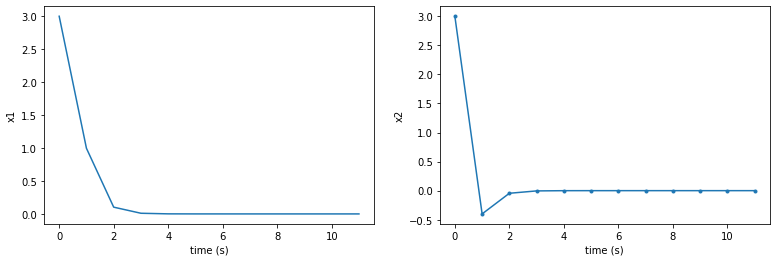

In [31]:
l = .1
env.reset()
print(env.state)
i_state = np.array([3,3])
env.set_state(i_state)
print(env.state)
states = []
time_limit = 10
time_log = [0]
actions = []
acc_time = 0
episode_reward = 0
while True:
    reward = 0
    x = env.state
    states.append(x)
    a_agent, tau = control_law(x, env, l=l)
    actions.append([a_agent, tau])
    print(x, a_agent, tau)
    acc_time += tau
    time_log.append(acc_time)
    env.set_state(next_state(x, a_agent, tau, env))
    if acc_time > time_limit:
        break
states.append(env.state)
actions.append(control_law(env.state, env, l=l))
states = np.array(states)
actions = np.array(actions)

plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.xlabel('time (s)')
plt.ylabel('x1')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('time (s)')
plt.ylabel('x2')
plt.plot(time_log, states[:,1])
plt.scatter(time_log, states[:,1], marker='.')
plt.show()

## approximate mb agent with NN

In [5]:
import warnings
warnings.filterwarnings('ignore')
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

Using TensorFlow backend.


In [10]:
actor = branch_actor((2,),(2,))
actor.compile(loss='mse', optimizer='adam')

In [7]:
# make train data
s1 = np.linspace(-7,7,100)
s2 = np.linspace(-7,7,100)
S1, S2 = np.meshgrid(s1, s2)
batch = []

for state in zip(S1.flatten(), S2.flatten()):
    state = np.array(state)
    action = control_law(state, env)
    batch.append([state, action])
    
batch = np.array(batch)

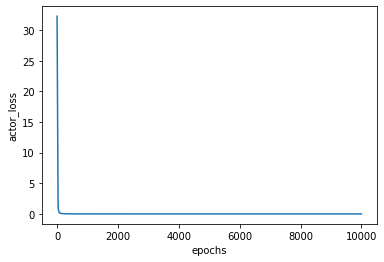

In [8]:
batch_size = 64

epochs = 10000
losses = []
for _ in range(epochs):
    indices = np.random.choice(range(10000),batch_size,replace=False)
    states = batch[:,0].reshape(10000,1,2)
    actions = batch[:,1]
    
    
    loss = actor.train_on_batch(states, actions)
    losses.append(loss)
    
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('actor_loss')
plt.show()


In [9]:
actor.save_weights('./saved_agent/mb_self_extend.h5')

In [13]:
env.reset()
# actor.load_weights('../saved_agent/learned_self_linear_ideal0_actor.h5')
# actor.load_weights('../saved_agent/learned_self_linear1_extend_actor.h5')
actor.load_weights('./saved_agent/mb_self_extend.h5')
initial_state = np.array([1., 2.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
    taus.append(tau)
    tau = np.clip(tau, .01, 10.)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=.1)
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(actor.predict_on_batch(env.state.reshape(1,1,2))[0][0])
states = np.array(states)
detail_states = np.array(detail_states)

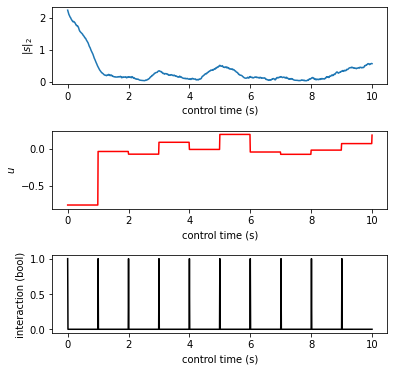

In [14]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()